In [1]:
from time import time
from os import listdir
from os.path import isdir, isfile
import glob
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 12})
results_dir = 'results'
processed_dir = 'processed'
plots_dir = 'plots'
dirlist = [d for d in listdir(f'{results_dir}') if isdir(f'{results_dir}/{d}') and (d != '.ipynb_checkpoints')]

In [3]:
dirlist

['1PGB_T0.001_d3.0',
 '1PGB_T0.001_d2.0',
 '1PGB_T0.001_d1.0',
 '1PGB_T0.001_d4.0',
 '1PGB_T0.001_d5.0']

In [4]:
Tlist = np.sort([float(d.split('_')[-2][1:]) for d in dirlist])
dirdict = {}
for T in Tlist:
    T_dirlist = [d for d in dirlist if str(T) in d]
    dmaxlist = [float(d.split('_')[-1][1:]) for d in T_dirlist]
    ord_dmaxlist = np.sort(dmaxlist)
        
    dirdict[str(T)] = [T_dirlist[dmaxlist.index(dmax)] for dmax in ord_dmaxlist]

In [5]:
dirdict

{'0.001': ['1PGB_T0.001_d1.0',
  '1PGB_T0.001_d2.0',
  '1PGB_T0.001_d3.0',
  '1PGB_T0.001_d4.0',
  '1PGB_T0.001_d5.0']}

In [6]:
def load_data(d):
    datafiles = np.array([f for f in listdir(f'{results_dir}/{d}') if isfile(f'{results_dir}/{d}/{f}') and 'data' in f])
    eq_file = datafiles[['eq' in datafile for datafile in datafiles]][0]
    file = datafiles[[not 'eq' in datafile for datafile in datafiles]][0]
    
    with open(f'{results_dir}/{d}/{eq_file}', 'r') as f:
        lines = f.readlines()
    eq_data = np.array([line.split('\t') for line in lines], dtype = float)
    
    with open(f'{results_dir}/{d}/{file}', 'r') as f:
        lines = f.readlines()
    data = np.array([line.split('\t') for line in lines], dtype = float)
    return eq_data, data


def load_muts(d):
    mutsfiles = np.array([f for f in listdir(f'{results_dir}/{d}') if isfile(f'{results_dir}/{d}/{f}') and 'mutants' in f])
    eq_file = mutsfiles[['eq' in mutsfile for mutsfile in mutsfiles]][0]
    file = mutsfiles[[not 'eq' in mutsfile for mutsfile in mutsfiles]][0]
    
    with open(f'{results_dir}/{d}/{eq_file}', 'r') as f:
        lines = f.readlines()
    eq_muts = np.array([[line.split('\t')[0], line.split('\t')[1][:-1]] for line in lines], dtype = str)
    
    with open(f'{results_dir}/{d}/{file}', 'r') as f:
        lines = f.readlines()
    muts = np.array([[line.split('\t')[0], line.split('\t')[1][:-1]] for line in lines], dtype = str)
    
    splitted_d = d.split('_')
    T = float(splitted_d[-2][1:])
    dmax = float(splitted_d[-1][1:])
    return eq_muts, muts, T, dmax

---
# Wall simulations

### dmax match

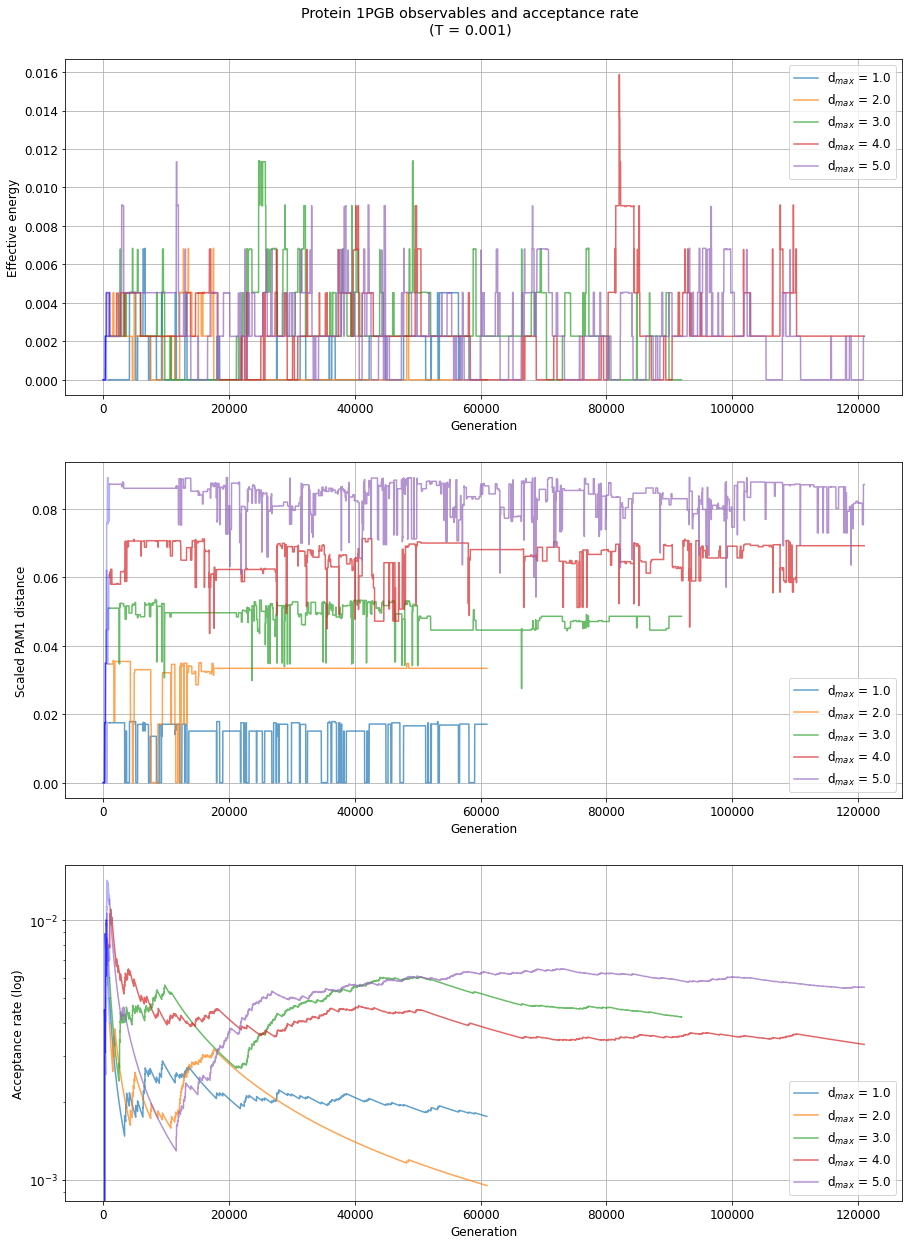

In [7]:
for T in dirdict:
    fig, (ax1, ax2, ax3) = plt.subplots(figsize = (15, 21), nrows = 3, ncols = 1)
    fig.suptitle(f'Protein 1PGB observables and acceptance rate\n(T = {T})', y = 0.915)

    dirlist = dirdict[T]
    for d in dirlist:
        eq_data, data = load_data(d)
        eq_gens, gens = eq_data[:, 0], data[:, 0]
        eq_energy, energy = eq_data[:, 1], data[:, 1]
        eq_distance, distance = eq_data[:, 3], data[:, 3]
        eq_ar, ar = eq_data[:, 5], data[:, 5]
        dmax, length = data[0, -2], data[0, -1]

        ax1.set_ylabel('Effective energy')
        ax1.plot(eq_gens, eq_energy, color = 'blue', alpha = 0.3)
        ax1.plot(gens, energy, alpha = 0.7, label = r'd$_{max}$ = ' + str(dmax))

        ax2.set_ylabel('Scaled PAM1 distance')
        ax2.plot(eq_gens, eq_distance/length, color = 'blue', alpha = 0.3)
        ax2.plot(gens, distance/length, alpha = 0.7, label = r'd$_{max}$ = ' + str(dmax))

        ax3.set_ylabel('Acceptance rate (log)')
        ax3.plot(eq_gens, eq_ar, color = 'blue', alpha = 0.3)
        ax3.plot(gens, ar, alpha = 0.7, label = r'd$_{max}$ = ' + str(dmax))

    for iax, ax in enumerate((ax1, ax2, ax3)): 
        ax.grid()
        ax.legend()
        ax.set_xlabel('Generation')
        if iax == 2: ax.set_yscale('log')

    plt.savefig(f'{plots_dir}/observables_comparison.png', bbox_inches='tight');

### Distribution check

In [8]:
dirlist = T_dirlist

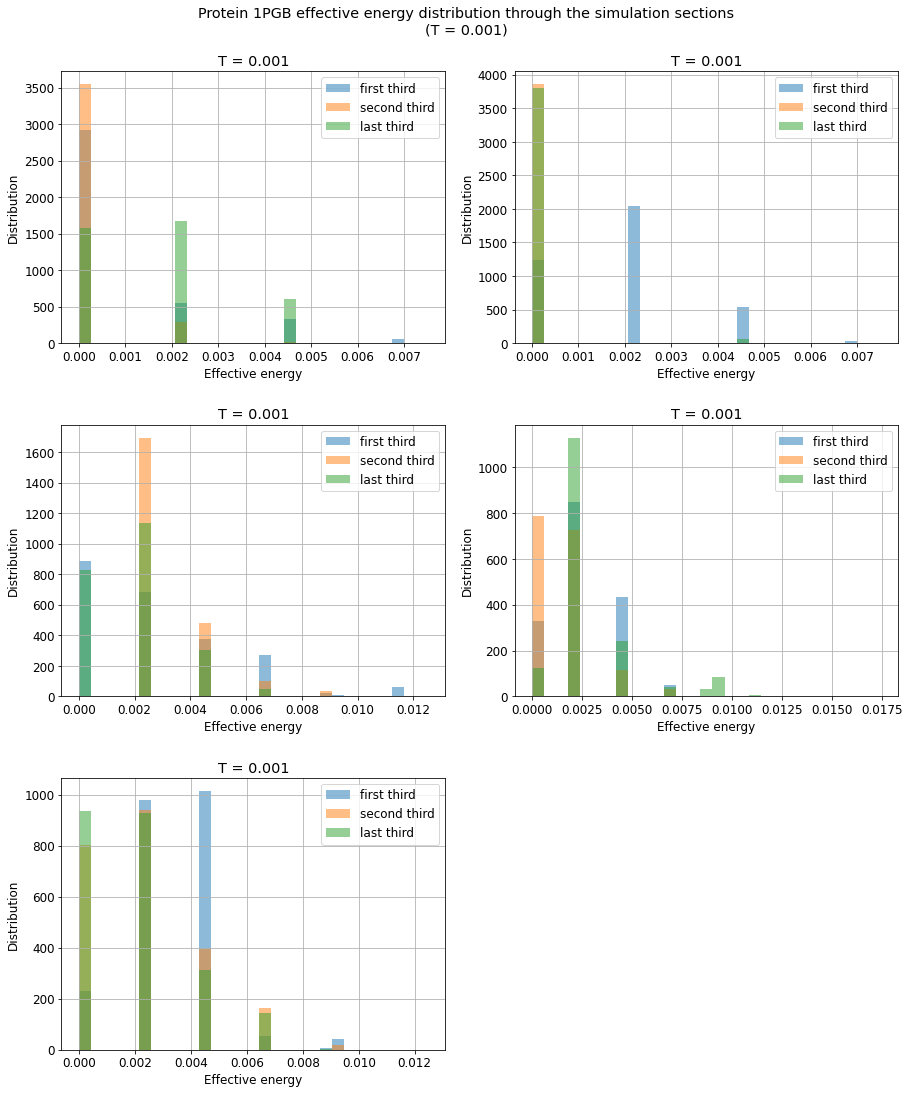

In [9]:
for T in dirdict:
    dirlist = dirdict[T]
    nplots = len(dirlist)
    nrows = int(nplots/2 + nplots%2)

    fig, axs = plt.subplots(figsize = (15, 6*nrows), nrows = nrows, ncols = 2)
    fig.suptitle(f'Protein 1PGB effective energy distribution through the simulation sections\n(T = {T})', y = 0.93)

    if len(dirlist)%2 == 1:
        axs[-1, -1].remove()

    for idx, d in enumerate(dirlist):
        nrow, ncol = int(idx/2), idx%2
        ax = axs[nrow, ncol]

        _, data = load_data(d)
        mutations, T = len(data), data[0, -3]
        sections = ['first', 'second', 'last']
        maxx, minn = np.max(data[:, 1]) * (11/10), np.min(data[:, 1]) * (9/10)
        if maxx != minn:
            bins = np.linspace(minn, maxx, 30)

        for idx, section in enumerate(sections):
            section_energy = data[int(idx * mutations/3):int((idx+1) * mutations/3), 1]
            ax.hist(section_energy, bins = bins, alpha = 0.5, density = True, label=f'{section} third')

        ax.set_title(f'T = {T}')
        ax.set_ylabel('Distribution')
        ax.set_xlabel(r'Effective energy')
        ax.legend(loc = 'best')
        ax.grid(True)

    plt.subplots_adjust(hspace = 0.3, wspace = 0.18)
    plt.savefig(f'{plots_dir}/energy_histograms.png', bbox_inches='tight');

### Sequences space exploration

In [12]:
T = 0.001
dmax = 5.
dirlist = dirdict[str(T)]
d = [d for d in dirlist if str(dmax) in d][0]

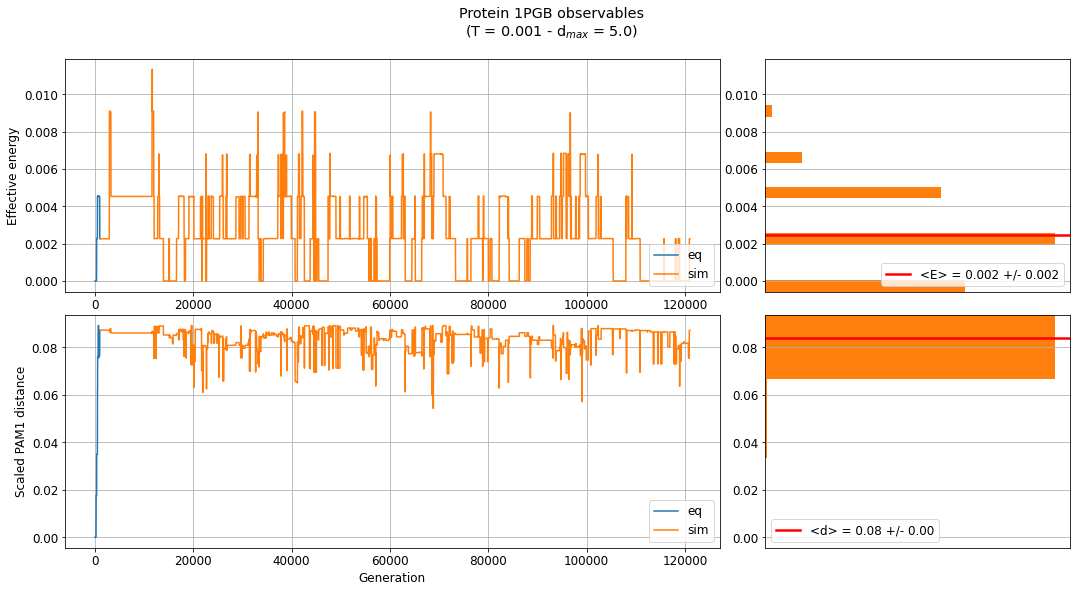

In [13]:
fig, axs = plt.subplots(figsize = (18, 9), ncols = 3, nrows = 2)
fig.suptitle(f'Protein 1PGB observables\n(T = {T} - ' + r'd$_{max}$' + f' = {dmax})', y = 0.96)

energy_gs = axs[0, 0].get_gridspec()
distance_gs = axs[1, 0].get_gridspec()
for ax in np.append(axs[0, :-1], axs[1, :-1]):
    ax.remove()
energy_ax = fig.add_subplot(energy_gs[0, :-1])
distance_ax = fig.add_subplot(distance_gs[1, :-1])

eq_data, data = load_data(d)
eq_generations, generations = eq_data[:, 0], data[:, 0]
tot_generations = np.append(eq_generations, generations[1:])
gamma, seq_length = data[0, -2], data[0, -1]
    
# energy
eq_energy, energy = eq_data[:, 1], data[:, 1]
energy_mean, energy_std = energy.mean(), energy.std()
    
energy_ax.plot(eq_generations, eq_energy, label = 'eq')
energy_ax.plot(generations, energy, label = 'sim')
energy_ax.set_ylabel('Effective energy')
energy_ax.legend(loc = 'lower right')
energy_ax.grid()
ylims = energy_ax.get_ylim()
    
ax = axs[0, -1]
color = energy_ax.get_lines()[1].get_color()
bins = np.linspace(ylims[0], ylims[1], 21)
ax.hist(energy, bins, density = True, color = color, orientation='horizontal')
xlims = ax.get_xlim()
ax.plot(xlims, [energy_mean, energy_mean], color = 'red', linewidth = 2.5, 
        label = f'<E> = {format(energy_mean, ".3f")} +/- {format(energy_std, ".3f")}')
    
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xticks([])
ax.yaxis.grid()
ax.legend(loc = 'lower right')
    
# distance
eq_distance, distance = eq_data[:, 3], data[:, 3]
distance_mean, distance_std = distance.mean(), distance.std()
    
distance_ax.plot(eq_generations, eq_distance/seq_length, label = f'eq')
distance_ax.plot(generations, distance/seq_length, label = f'sim')
distance_ax.set_xlabel('Generation')
distance_ax.set_ylabel('Scaled PAM1 distance')
distance_ax.legend(loc = 'lower right')
distance_ax.grid()
ylims = distance_ax.get_ylim()
    
ax = axs[1, -1]
color = distance_ax.get_lines()[1].get_color()
bins = np.linspace(0, 1, 31)
ax.hist(distance/seq_length, bins, density = True, color = color, orientation='horizontal')
xlims = ax.get_xlim()
ax.plot(xlims, [distance_mean/seq_length, distance_mean/seq_length], color = 'red', linewidth = 2.5, 
        label = f'<d> = {format(distance_mean/seq_length, ".2f")} +/- {format(distance_std/seq_length, ".2f")}')
    
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xticks([])
ax.yaxis.grid()
ax.legend(loc = 'lower left')
    
plt.subplots_adjust(hspace = 0.1, wspace = 0.15)
plt.savefig(f'{plots_dir}/observables_T{T}_d{dmax}.png', bbox_inches='tight');

### Groups distances distribution: Hamming

### Processed data

In [14]:
dirlist = T_dirlist

In [15]:
def process_data(dirlist, load = False):
    if load:
        processed_data = pd.read_csv(f'{processed_dir}/data/processed_data.csv')
        processed_data = processed_data.drop(columns = ['Unnamed: 0'])
        
    else:
        columns = ['mean_energy', 'max_energy', 'std_energy', 
                   'mean_distance', 'max_distance', 'std_distance', 
                   'acceptance_rate',
                   'T', 'dmax', 'seq_length']
        repos = np.zeros((len(columns), len(dirlist)))

        for idx, d in enumerate(dirlist):
            _, data = load_data(d)

            repos[0, idx] = data[:, 1].mean()
            repos[1, idx] = data[:, 1].max()
            repos[2, idx] = data[:, 1].std()

            repos[3, idx] = data[:, 3].mean()/data[-1, -1]
            repos[4, idx] = data[:, 3].max()/data[-1, -1]
            repos[5, idx] = data[:, 3].std()/data[-1, -1]

            repos[6, idx] = data[-1, 5]

            repos[7, idx] = data[-1, -3]
            repos[8, idx] = data[-1, -2]
            repos[9, idx] = data[-1, -1]

        processed_data = pd.DataFrame()
        for column, repo in zip(columns, repos):
            processed_data[column] = repo
            
        T = processed_data.loc[0, 'T']
        processed_data.to_csv(f'{processed_dir}/data/processed_data_T{T}.csv')    
    return processed_data

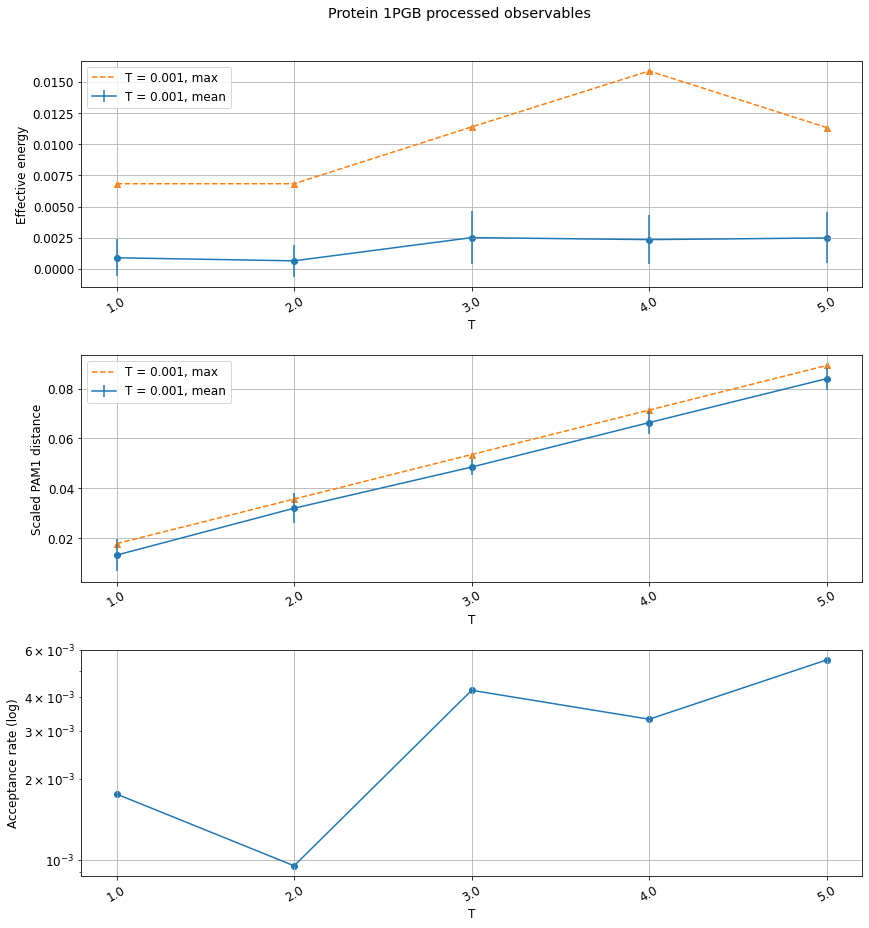

In [16]:
for T in dirdict:
    dirlist = dirdict[T]
    processed_data = process_data(dirlist, load = False)
    
    fig, axs = plt.subplots(figsize = (14, 15), nrows = 3, ncols = 1)
    fig.suptitle(f'Protein 1PGB processed observables', y = 0.93)

    # energy
    ax = axs[0]
    ax.errorbar(processed_data['dmax'], processed_data[f'mean_energy'], yerr=processed_data[f'std_energy'], label=f'T = {T}, mean')
    ax.plot(processed_data['dmax'], processed_data[f'max_energy'], label=f'T = {T}, max', linestyle = '--')
    ax.scatter(processed_data['dmax'], processed_data[f'mean_energy'])
    ax.scatter(processed_data['dmax'], processed_data[f'max_energy'], marker = '^')
    ax.set_ylabel('Effective energy')

    # distance
    ax = axs[1]
    ax.errorbar(processed_data['dmax'], processed_data[f'mean_distance'], yerr=processed_data[f'std_distance'], label=f'T = {T}, mean')
    ax.plot(processed_data['dmax'], processed_data[f'max_distance'], label=f'T = {T}, max', linestyle = '--')
    ax.scatter(processed_data['dmax'], processed_data[f'mean_distance'])
    ax.scatter(processed_data['dmax'], processed_data[f'max_distance'], marker = '^')
    ax.set_ylabel('Scaled PAM1 distance')

    # acceptance rate
    ax = axs[2]
    ax.plot(processed_data['dmax'], processed_data['acceptance_rate'], label = f'T = {T}')
    ax.scatter(processed_data['dmax'], processed_data['acceptance_rate'])
    ax.set_ylabel(f'Acceptance rate (log)')

    xticks = processed_data['dmax']
    for idx, ax in enumerate(axs):
        ax.set_xlabel('T')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks.astype(str), rotation = 30)

        ax.grid()
        if idx < 2: ax.legend()
        else: ax.set_yscale('log')

    plt.subplots_adjust(hspace = 0.3, wspace = 0.15)
    plt.savefig(f'{plots_dir}/processed_observables.png', bbox_inches='tight');

### Explored sequences

In [17]:
step = 1_000

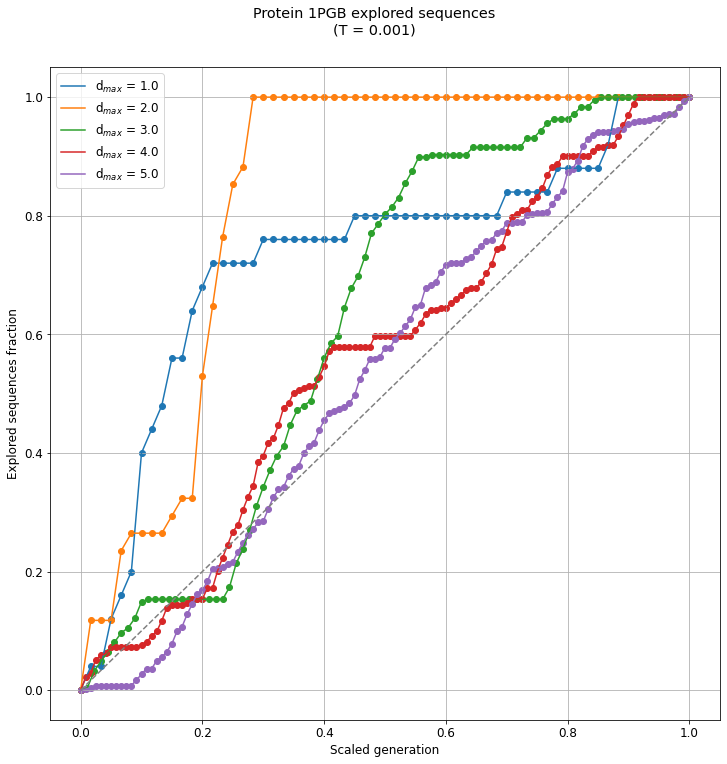

In [18]:
for T in dirdict:
    dirlist = dirdict[T]

    fig = plt.figure(figsize = (12, 12))
    fig.suptitle(f'Protein 1PGB explored sequences\n(T = {T})', y = 0.95)

    for d in dirlist:
        eq_muts, muts, T, dmax = load_muts(d)
        eq_gens, gens = eq_muts[:, 0].astype(float), muts[:, 0].astype(float)
        eq_mutants, mutants = eq_muts[:, 1], muts[:, 1]

        nsteps = int(len(mutants) / step)
        unique_mutants = np.array([len(np.unique(mutants[:(nstep * step)])) for nstep in range(nsteps + 1)])
        unique_mutants = unique_mutants/unique_mutants[-1]

        plt.plot(np.linspace(0., 1., len(unique_mutants)), unique_mutants, label = r'd$_{max}$ = ' + str(dmax))
        plt.scatter(np.linspace(0., 1., len(unique_mutants)), unique_mutants)

    plt.plot(np.linspace(0., 1., len(unique_mutants)), np.linspace(0., 1., len(unique_mutants)), linestyle = '--', color = 'gray')
    plt.xlabel('Scaled generation')
    plt.ylabel('Explored sequences fraction')
    plt.legend()
    plt.grid()

    plt.savefig(f'{plots_dir}/explored_sequences_T{T}.png', bbox_inches='tight');

### Site entropy

In [52]:
dirlist = T_dirlist

In [53]:
distmatrix = pd.read_csv(f'{processed_dir}/data/DistPAM1.csv')
distmatrix = distmatrix.drop(columns = ['Unnamed: 0'])
residues = tuple(distmatrix.columns)
distmatrix = np.array(distmatrix)

In [54]:
def get_sites_entropy(d):
    _, muts, T, gamma = load_muts(d)
    mutants = muts[:, 1].astype(str)
    mutants = np.array([list(mutant) for mutant in mutants])
    
    mutations = mutants.T
    sites_entropy = np.zeros(mutations.shape[0])
    for isite, site_mutations in enumerate(mutations):
        res_freqs = np.array([
            len(site_mutations[site_mutations == residue]) / len(site_mutations) for residue in residues
        ])
        res_freqs[res_freqs == 0.0] = 1.
        sites_entropy[isite] = -np.sum(res_freqs * np.log(res_freqs))
    
    return sites_entropy

In [61]:
Tlist = [0.001] #, 0.003, 0.001]
cutoff = 1.0

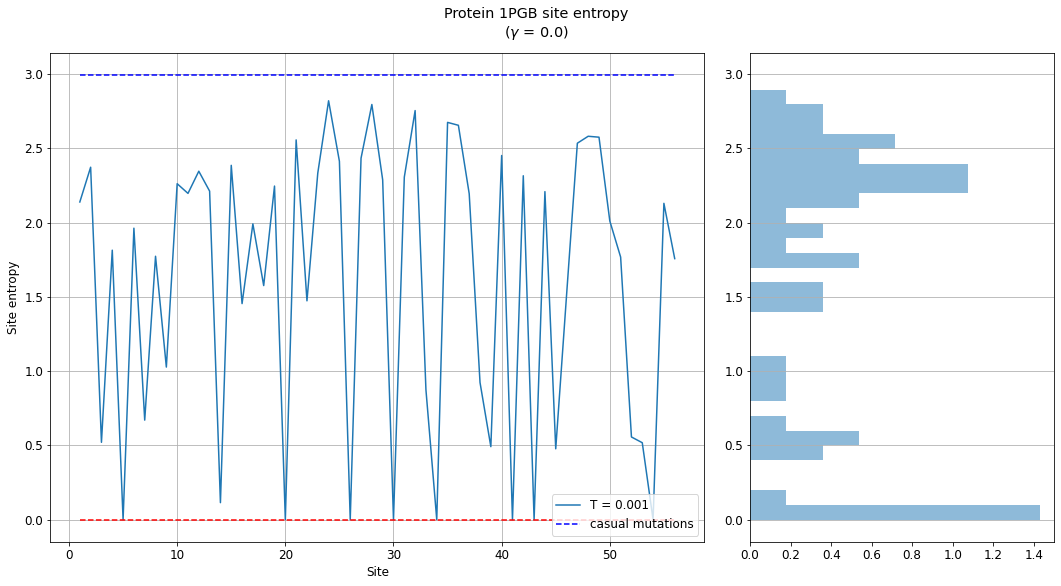

In [62]:
max_entropy = np.log(len(residues))

fig, axs = plt.subplots(figsize = (18, 9), ncols = 3, nrows = 1)
fig.suptitle(f'Protein 1PGB site entropy\n' + r'($\gamma$ = 0.0)', y = 0.95)

gs = axs[0].get_gridspec()
for ax in axs[:-1]:
    ax.remove()
plot_ax = fig.add_subplot(gs[:-1])
hist_ax = axs[-1]

for iT, T in enumerate(Tlist):
    d = [d for d in dirlist if str(T) in d][0]
    sites_entropy = get_sites_entropy(d)
    sites = np.arange(1, len(sites_entropy) + 1)
    
    # site entropy plots
    plot_ax.plot(np.arange(1, len(sites_entropy) + 1), sites_entropy, label = f'T = {T}')
    
    # site entropy histograms
    color = plot_ax.get_lines()[iT].get_color()
    bins = np.linspace(0., max_entropy, 31)
    hist_ax.hist(sites_entropy, bins, density = True, color = color, alpha = 0.5, orientation='horizontal')
    hist_ax.yaxis.grid()
        
plot_ax.plot(sites, [0.] * len(sites_entropy), color = 'red', linestyle = '--')
plot_ax.plot(sites, [max_entropy] * len(sites_entropy), color = 'blue', linestyle = '--', label = 'casual mutations')
    
plot_ax.set_ylabel('Site entropy')
plot_ax.set_xlabel('Site')
plot_ax.legend(loc = 'lower right')
plot_ax.grid()

plt.subplots_adjust(hspace = 0.1, wspace = 0.15)
plt.savefig(f'{plots_dir}/site_entropy.png', bbox_inches='tight');

In [63]:
for iT, T in enumerate(Tlist):
    d = [d for d in dirlist if str(T) in d][0]
    sites_entropy = get_sites_entropy(d)
    low_entropy_sites = np.where(sites_entropy < cutoff)[0] + 1

    print(f'Low entropy 1PGB sites (cutoff = {cutoff}):')
    for site in low_entropy_sites[:-1]:
        print(f'{site}, ', end = '')
    print(low_entropy_sites[-1])
    if iT < len(Tlist)-1: print()

Low entropy 1PGB sites (cutoff = 1.0):
3, 5, 7, 14, 20, 26, 30, 33, 34, 38, 39, 41, 43, 45, 52, 53, 54


### Sites correlation matrix

In [70]:
dirlist = T_dirlist

In [71]:
def fixed_sites_correlation(mutations_i, mutations_j):
    assert len(mutations_i) == len(mutations_j), 'Wow... how?'
    mutations = len(mutations_i)
    
    # Calculate single-site frequencies
    c_i = np.array([len(mutations_i[mutations_i == residue]) / mutations for residue in residues])
    c_j = np.array([len(mutations_j[mutations_j == residue]) / mutations for residue in residues])
    
    # Calculate...
    c_ij = np.zeros((len(residues), len(residues)))
    log_c_ij = np.zeros((len(residues), len(residues)))
    for isigma, sigma in enumerate(residues):
        sigma_mask = (mutations_i == sigma).astype(int)
        for ipi, pi in enumerate(residues):
            pi_mask = (mutations_j == pi).astype(int)
            
            # ...site-site frequencies
            c_ij[isigma, ipi] = np.sum(sigma_mask * pi_mask) / mutations
            # ...log matrix
            if c_ij[isigma, ipi] != 0.:
                log_c_ij[isigma, ipi] = np.log(c_ij[isigma, ipi] / (c_i[isigma] * c_j[ipi]))                
        
    c_ij = np.sum(c_ij * log_c_ij)
    return c_ij

def get_site_correlation(_input):
    if type(_input) == str:
        print('Directory as input.')
        d = _input
        _, muts, T, gamma = load_muts(d)
        mutants = muts[:, 1].astype(str)
    elif type(_input) == list:
        print('Mutants list as input.')
        mutants = _input
        
    mutants = np.array([list(mutant) for mutant in mutants])
    length, mutations = len(mutants[0]), len(mutants)
    
    c = np.zeros((length, length))
    sites = np.arange(0, length)
    print('Calculating correlations for site...')
    for i in sites:
        print(f'{i+1}\t ({format(100. * (i+1) / length, ".2f")}%)')
        for j in sites[i:]:
            c[i, j] = fixed_sites_correlation(mutants[:, i], mutants[:, j])
            c[j, i] = c[i, j]
    return c

In [98]:
T = 0.001

In [73]:
d = [d for d in dirlist if str(T) in d][0]
c = get_site_correlation(d)

Directory as input.
Calculating correlations for site...
1	 (1.79%)
2	 (3.57%)
3	 (5.36%)
4	 (7.14%)
5	 (8.93%)
6	 (10.71%)
7	 (12.50%)
8	 (14.29%)
9	 (16.07%)
10	 (17.86%)
11	 (19.64%)
12	 (21.43%)
13	 (23.21%)
14	 (25.00%)
15	 (26.79%)
16	 (28.57%)
17	 (30.36%)
18	 (32.14%)
19	 (33.93%)
20	 (35.71%)
21	 (37.50%)
22	 (39.29%)
23	 (41.07%)
24	 (42.86%)
25	 (44.64%)
26	 (46.43%)
27	 (48.21%)
28	 (50.00%)
29	 (51.79%)
30	 (53.57%)
31	 (55.36%)
32	 (57.14%)
33	 (58.93%)
34	 (60.71%)
35	 (62.50%)
36	 (64.29%)
37	 (66.07%)
38	 (67.86%)
39	 (69.64%)
40	 (71.43%)
41	 (73.21%)
42	 (75.00%)
43	 (76.79%)
44	 (78.57%)
45	 (80.36%)
46	 (82.14%)
47	 (83.93%)
48	 (85.71%)
49	 (87.50%)
50	 (89.29%)
51	 (91.07%)
52	 (92.86%)
53	 (94.64%)
54	 (96.43%)
55	 (98.21%)
56	 (100.00%)


In [74]:
np.save(f'{processed_dir}/data/sim_correlation_matrix_T{T}.npy', c)

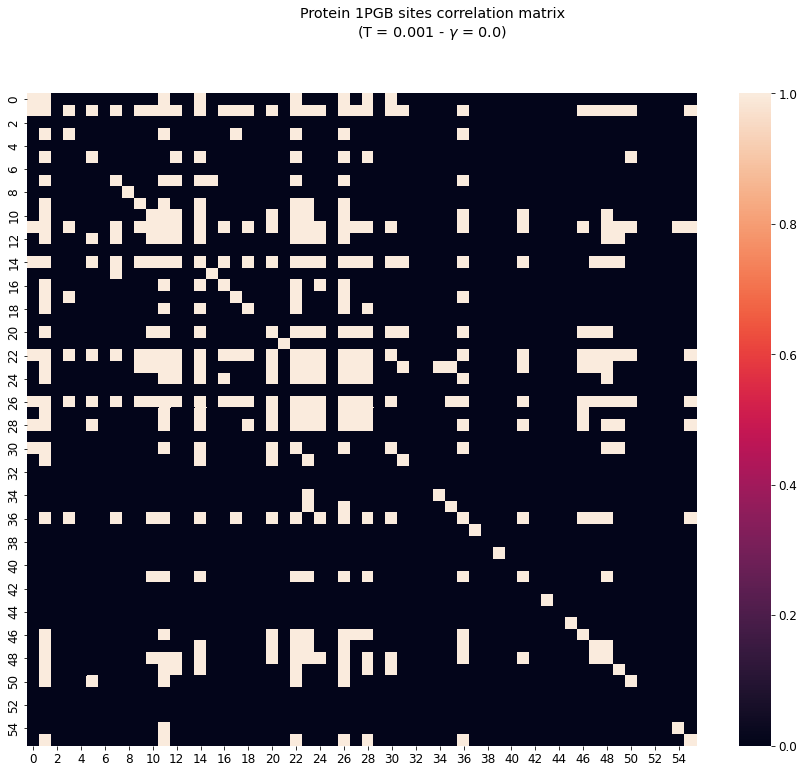

In [99]:
fig = plt.figure(figsize = (15, 12))
fig.suptitle(f'Protein 1PGB sites correlation matrix\n(T = {T} - ' + r'$\gamma$ = 0.0)')
sns.heatmap(
    data = c > 0.9,
    vmin = 0., vmax = 1.,
    #cmap = 'Dark2'
);

### Site correlation matrix for 1PGB alignement

In [60]:
dirlist = T_dirlist

In [61]:
with open(f'{processed_dir}/1PGB_alignement/1PGB_alignement_results.txt', 'r') as f:
    lines = f.readlines()

exp_mutants = [line.split('\t')[0] for line in lines]
scaled_distances = [float(line.split('\t')[1]) for line in lines[1:]]
energies = [float(line.split('\t')[2]) for line in lines[1:]]
wt_sequence = exp_mutants.pop(0)
length = len(wt_sequence)

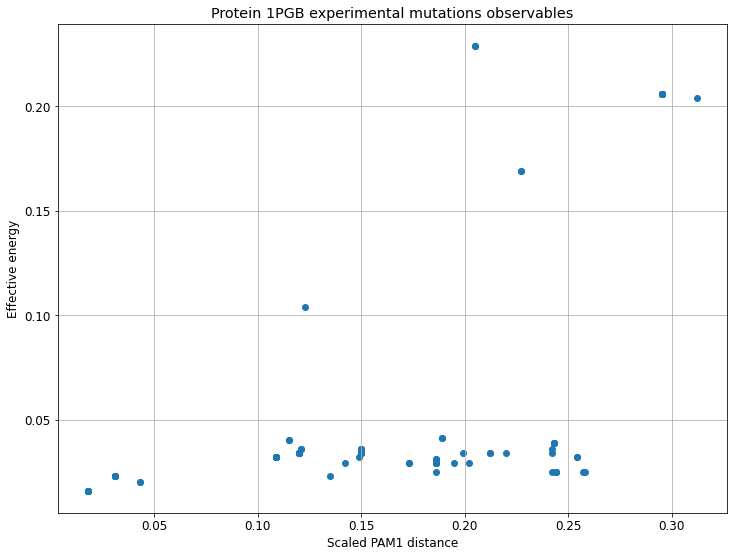

In [62]:
fig = plt.figure(figsize = (12, 9))
plt.scatter(scaled_distances, energies)
plt.title('Protein 1PGB experimental mutations observables')
plt.ylabel('Effective energy')
plt.xlabel('Scaled PAM1 distance')
plt.grid();

In [63]:
exp_c = get_site_correlation(exp_mutants)

Mutants list as input.
Calculating correlations for site...
1	 (1.79%)
2	 (3.57%)
3	 (5.36%)
4	 (7.14%)
5	 (8.93%)
6	 (10.71%)
7	 (12.50%)
8	 (14.29%)
9	 (16.07%)
10	 (17.86%)
11	 (19.64%)
12	 (21.43%)
13	 (23.21%)
14	 (25.00%)
15	 (26.79%)
16	 (28.57%)
17	 (30.36%)
18	 (32.14%)
19	 (33.93%)
20	 (35.71%)
21	 (37.50%)
22	 (39.29%)
23	 (41.07%)
24	 (42.86%)
25	 (44.64%)
26	 (46.43%)
27	 (48.21%)
28	 (50.00%)
29	 (51.79%)
30	 (53.57%)
31	 (55.36%)
32	 (57.14%)
33	 (58.93%)
34	 (60.71%)
35	 (62.50%)
36	 (64.29%)
37	 (66.07%)
38	 (67.86%)
39	 (69.64%)
40	 (71.43%)
41	 (73.21%)
42	 (75.00%)
43	 (76.79%)
44	 (78.57%)
45	 (80.36%)
46	 (82.14%)
47	 (83.93%)
48	 (85.71%)
49	 (87.50%)
50	 (89.29%)
51	 (91.07%)
52	 (92.86%)
53	 (94.64%)
54	 (96.43%)
55	 (98.21%)
56	 (100.00%)


In [64]:
np.save(f'{processed_dir}/data/exp_correlation_matrix.npy', exp_c)

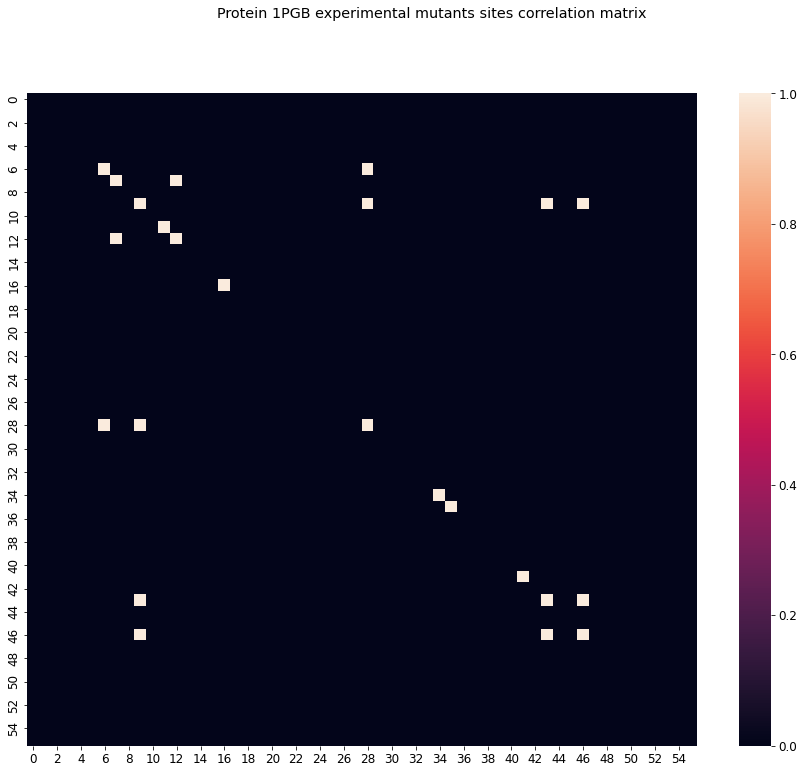

In [65]:
fig = plt.figure(figsize = (15, 12))
fig.suptitle(f'Protein 1PGB experimental mutants sites correlation matrix')
sns.heatmap(
    data = exp_c > 0.6,
    vmin = 0., vmax = 1.,
    #cmap = 'Dark2'
);

---
# SM simulations, high and low gamma

### Wt frequency check

In [66]:
dirlist = gamma_dirlist

Wild type protein frequency for high-gamma simulations:
- gamma = 6.0	frequency = 0.669
- gamma = 7.0	frequency = 0.948
- gamma = 8.0	frequency = 1.000
- gamma = 9.0	frequency = 1.000


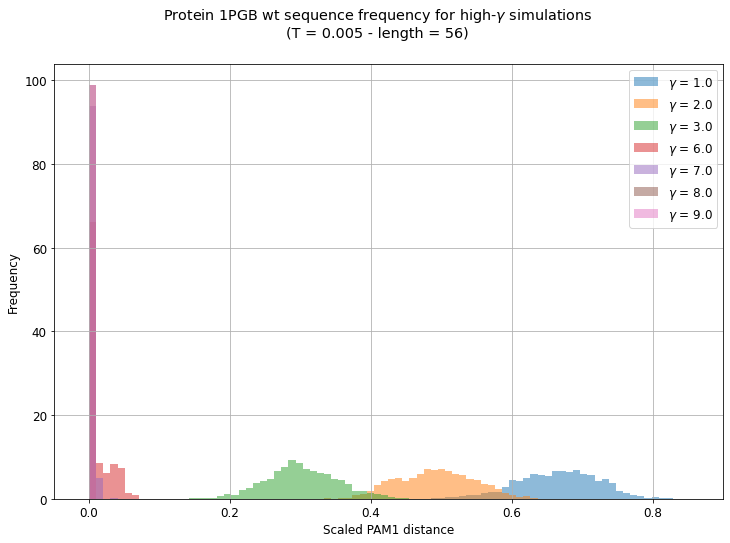

In [67]:
fig = plt.figure(figsize = (12, 8))

print('Wild type protein frequency for high-gamma simulations:')
for d in dirlist:
    _, data = load_data(d)
    scaled_distances = data[:, 3] / data[0, -1]
    T, gamma, length = data[0, -3], data[0, -2], data[0, -1]
    
    wt_frequency = len(scaled_distances[scaled_distances == 0.]) / len(scaled_distances)
    if wt_frequency > 0.5:
        print(f'- gamma = {gamma}\tfrequency = {format(wt_frequency, ".3f")}')
    
    plt.hist(scaled_distances, bins = np.linspace(0., 1., 100), label = r'$\gamma$ = ' + str(gamma),
             density = True, alpha = 0.5)
    
fig.suptitle(r'Protein 1PGB wt sequence frequency for high-$\gamma$ simulations' + f'\n(T = {T} - length = {int(length)})')
plt.xlabel('Scaled PAM1 distance')
plt.ylabel('Frequency')
plt.legend()
plt.xlim([-0.05, 0.9])
plt.grid();

### Mean distance prediction

In [200]:
gamma_dirlist

['SM_1PGB_T0.005_g1.0',
 'SM_1PGB_T0.005_g2.0',
 'SM_1PGB_T0.005_g3.0',
 'SM_1PGB_T0.005_g6.0',
 'SM_1PGB_T0.005_g7.0',
 'SM_1PGB_T0.005_g8.0',
 'SM_1PGB_T0.005_g9.0']

In [201]:
partial_dirlist = [
    'SM_1PGB_T0.005_g1.0',
    'SM_1PGB_T0.005_g2.0',
    'SM_1PGB_T0.005_g3.0',
    'SM_1PGB_T0.005_g6.0',
    'SM_1PGB_T0.005_g7.0'
]

In [202]:
dirlist = partial_dirlist

In [203]:
def load_lists(dirlist, idx_d = 3, idx_g = -2):  # PAM1 distances
    gammas, dlists = [], []
    for d in dirlist:
        _, data = load_data(d)
        dlists.append( list(data[:, idx_d]) )
        gammas.append( data[0, idx_g] )
        
    return gammas, dlists

In [204]:
gammas, dlists = load_lists(dirlist, idx_d = 3, idx_g = -2)

In [206]:
def reweight_mean(dlist, old_gamma, new_gamma):
    dlist = np.array(dlist)
    denominator = np.exp(-(new_gamma - old_gamma) * dlist)
    numerator = dlist * denominator
    return np.mean(numerator) / np.mean(denominator)

def get_reweighted_means(dlists, gammas, return_matrix = False):
    means_matrix = np.zeros((len(gammas), len(gammas)), dtype = float)
    for row in range(len(gammas)):
        means_matrix[row, row] = np.mean(dlists[row])
        for col in range(len(gammas)):
            if col == row: continue
            means_matrix[row, col] = reweight_mean(dlists[col], gammas[col], gammas[row])

    means = np.mean(means_matrix, axis = 1)
    if return_matrix:
        return means, means_matrix
    else:
        return means

def predict_means(dlists, gammas, new_gamma):
    mean = 0.
    for dlist, old_gamma in zip(dlists, gammas):
        mean += reweight_mean(dlist, old_gamma, new_gamma)
    return mean / len(gammas)

In [207]:
sim_means = np.array([np.mean(dlist) for dlist in dlists])
rew_means, means_matrix = get_reweighted_means(dlists, gammas, return_matrix = True)

In [209]:
sim_means

array([37.25659198, 27.5303397 , 16.89763139,  0.59931105,  0.04544714])

In [208]:
means_matrix

array([[37.25659198, 33.62870289, 24.87243771,  3.64044179,  1.826902  ],
       [28.90478729, 27.5303397 , 23.25780357,  3.54157067,  1.63682356],
       [27.53871326, 10.46608612, 16.89763139,  3.33062753,  1.20546626],
       [26.73400356,  9.25675157,  8.62362856,  0.59931105,  0.10974316],
       [26.68382813,  9.18692173,  8.52414811,  0.12714563,  0.04544714]])

In [225]:
dirlist = T_dirlist
d = [d for d in dirlist if str(T) in d][0]
_, data = load_data(d)
length = data[0, -1]
true_dmean = data[:, 3].mean() / length

In [228]:
print('Predicted mean at gamma = 0. using reweighted distances:')
for dlist, gamma in zip(dlists, gammas):
    print(f'gamma = {gamma} -> gamma = 0. --  dmean = {format(predict_means([dlist], [gamma], 0.)/length, ".4f")}  --  true dmean = {format(true_dmean, ".4f")}')

Predicted mean at gamma = 0. using reweighted distances:
gamma = 1.0 -> gamma = 0. --  dmean = 0.8018  --  true dmean = 0.8055
gamma = 2.0 -> gamma = 0. --  dmean = 0.6221  --  true dmean = 0.8055
gamma = 3.0 -> gamma = 0. --  dmean = 0.4537  --  true dmean = 0.8055
gamma = 6.0 -> gamma = 0. --  dmean = 0.0658  --  true dmean = 0.8055
gamma = 7.0 -> gamma = 0. --  dmean = 0.0338  --  true dmean = 0.8055
